In [1]:
import os
from configparser import ConfigParser
path_config_file = os.getcwd().split('docrv2_sroie')[0] + 'docrv2_sroie/' + 'config.ini'
common_variable = ConfigParser()
common_variable.read(path_config_file)

print(common_variable.sections())
print(common_variable['database']['module_path'])
print(common_variable['database']['DB_BASE'])

import sys
sys.path.append(common_variable['database']['module_path'])
from db_util import *
from db import *

import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import time

from parse import parse
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from glob import glob
from tqdm import tqdm_notebook

['database', 'mlflow', 'font']
/home/dk/docrv2_sroie/modules/database/
/home/dk/docrv2_sroie/DB/


In [6]:
dblist = ['/media/dk/HDD/DB/exp_result_000',
         '/media/dk/HDD/DB/exp_result_001',
         '/media/dk/HDD/DB/exp_result_002',
         '/media/dk/HDD/DB/exp_result_003',
         '/media/dk/HDD/DB/exp_result_004',
         '/media/dk/HDD/DB/exp_result_005',
         '/media/dk/HDD/DB/exp_result_006',
         '/media/dk/HDD/DB/exp_result_007',
         '/media/dk/HDD/DB/exp_result_008',
         '/media/dk/HDD/DB/exp_result_009']
dblist = ['/home/dk/docrv2_sroie/DB/raw_test_task12_img_txt_halfsized']
#dblist = ['/home/dk/docrv2_sroie/DB/inference_crop_0831_thr05_all']

(616, 1230)
(154, 308)


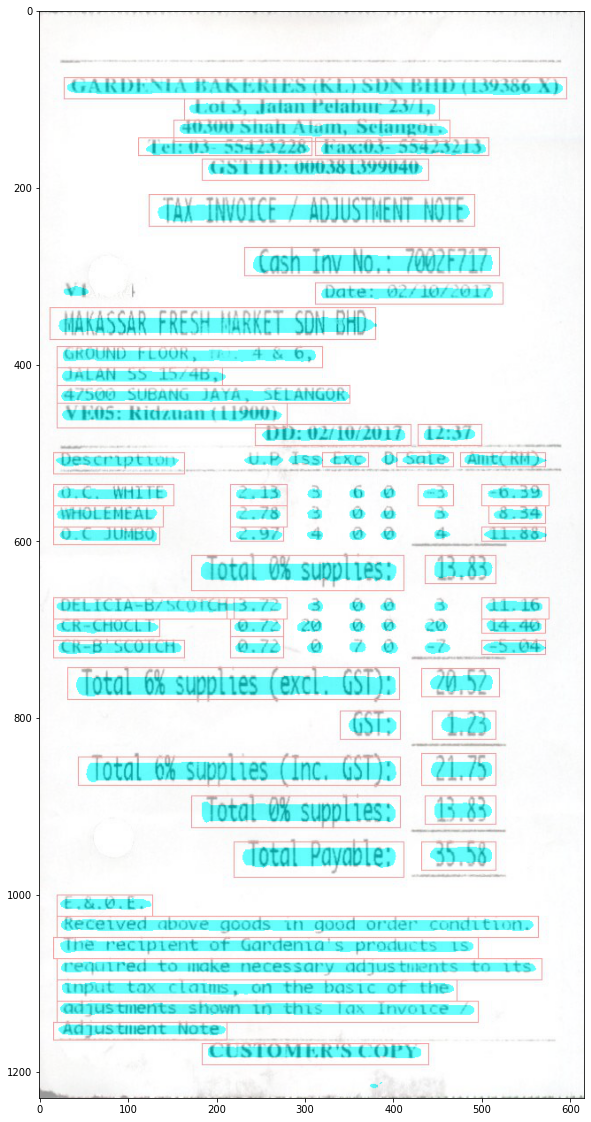

In [77]:
d = open_env('/home/dk/docrv2_sroie/DB/raw_test_task12_img_txt_halfsized_preview_detection/')
plt.figure(figsize=(40,20))
ind = 3

plt.imshow(read_data_from_db_by_index(d,'img',ind))
plt.imshow(np.array(np.array(read_data_from_db_by_index(d,'img',ind+361).resize(
    read_data_from_db_by_index(d,'img',ind).size),dtype=np.float32)/255<0.3,dtype=np.float32),alpha=0.6)
print(read_data_from_db_by_index(d,'img',ind).size)
print(read_data_from_db_by_index(d,'img',ind+361).size)

In [15]:
"""
Evalution (1)
"""
# raw db
for idx, dbpath in enumerate(dblist):
    raw_data_db_path = '/home/dk/docrv2_sroie/DB/raw_test_task12_img_txt'
    
    datadb = open_env(path=raw_data_db_path)
    img_ref = read_bulk_data_from_db(datadb, prefix='ref')

    # target db
    target_db_name = os.path.basename(dbpath)
    #target_db_path = '/home/dk/docrv2_sroie/temp/raw_test_task12_img_txt_10imtest'
    target_db_path = dbpath
    
    target_db = open_env(path=target_db_path)

    # img = read_bulk_data_from_db(target_db, prefix='img')
    # img_c = read_bulk_data_from_db(datadb, prefix='img_c')
    char_c = read_bulk_data_from_db(target_db, prefix='char_c')
    # word_c = read_bulk_data_from_db(datadb, prefix='word_c')

    """
    Evalution (2)
    """
    #target_db_name = 'train_img_10'
    output_path = '/home/dk/docrv2_sroie/evaluation/task1/'
    output_path = os.path.join(output_path, target_db_name)
    os.makedirs(output_path, exist_ok=True)

    # create submission txt for each images
    for idx in tqdm(range(len(img_ref))):
        tchar = char_c[idx]
        rmlist = []
        oklist = []
        for ii in range(len(tchar)):
            tchar[ii] = [float (i) for i in tchar[ii][0:8]]
            tchar[ii] = [int (i) for i in tchar[ii][0:8]]
            #tchar[ii] = [tchar[ii][0],tchar[ii][1],tchar[ii][4],tchar[ii][1],
            #            tchar[ii][4],tchar[ii][5],tchar[ii][0],tchar[ii][5]]
            if tchar[ii][0] > tchar[ii][4]:
                rmlist.append(ii)
            elif tchar[ii][1] > tchar[ii][5]:
                rmlist.append(ii)
            else:
                oklist.append(ii)
        
        tchar_temp = []
        for oki in oklist:
            tchar_temp.append(tchar[oki])
        tchar = tchar_temp
        
        txt_filename = img_ref[idx]+'.txt'
        df = pd.DataFrame(tchar)
        df.to_csv(os.path.join(output_path,txt_filename),sep=',',index=False,header=False)

        """
    Evaluation (3)
    """
    zip_name = 'submit_'+target_db_name+'_'
    shutil.make_archive(zip_name, 'zip', output_path) # to avoid including submit.zip

    # move submit.zip to task evaluation path
    eval_path = '/home/dk/docrv2_sroie/evaluation/task1/'
    try:
        shutil.move(os.path.join(os.getcwd(), zip_name+".zip"), eval_path) # move zip to output dir
    except:
        now = time.localtime()
        change_zip_name = zip_name+"{}{}{}".format(str(now.tm_hour), str(now.tm_min), str(now.tm_sec))
        os.rename(os.path.join(os.getcwd(), zip_name+".zip"),
                  os.path.join(os.getcwd(), change_zip_name+'.zip')
                 )
        zip_name = change_zip_name
        shutil.move(os.path.join(os.getcwd(), zip_name+".zip"), eval_path) # move zip to output dir

    # # copy gt.zip to task evaluation path
    # gt_path = '/media/myungsungkwak/msdisk/docrv2_data/d2gan_inference/gt/'
    # gt_name = "gt.zip"
    # shutil.copy(gt_path+gt_name, eval_path)

    print("Run command in {}\n$ python script.py -g=gt.zip -s={}.zip".format(eval_path, zip_name))

100%|██████████| 361/361 [00:00<00:00, 801.90it/s]

Run command in /home/dk/docrv2_sroie/evaluation/task1/
$ python script.py -g=gt.zip -s=submit_raw_test_task12_img_txt_halfsized_143853.zip


In [16]:
rmlist

[37]

Run command in /home/dk/docrv2_sroie/evaluation/task1/
$ python script.py -g=gt.zip -s=submit9438.zip
